# Adversarial Autoencoder

Adversarial autoencoder is regularized by matching the aggregated posterior $q(z)$ to an arbitrary prior distribution $p(z)$. The generator of the adversarial network is also the encoder of the autoencoder $q(z|x)$. The encoder or generator of the network ensures the aggregated posterior distribution can fool the discriminative adversarial network into thinking that the hidden code $q(z)$ comes from the true prior distribution $p(z)$.

Adversarial autoencoder is trained jointly in two phases - reconstruction phase and regularisation phase. In reconstruction phase, autoencoder updates the encoder and decoder to minimise the reconstruction error. In regularisation phase, adversarial network first updates its discriminator to tell apart true samples (generated using the prior $p(z)$) from the generated samples (generated by encoder or generator aggregrated posterior $q(z)$). The adversarial network then updates its generator to confuse the discriminator. Once training is done, decoder will define the generative model that maps the imposed prior $p(z)$ to the data distribution $p_d(x)$



In [1]:
import pickle
import numpy as np
import pandas as pd
import tqdm

# pytorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
%matplotlib inline

# Arguments

In [207]:
class Args:
    """Dummy argument class
    """
    def __init__(self):
        # batch size for training phase
        self.train_batch_size = 100
        # batch size for testing phase
        self.test_batch_size = 100
        self.seed = 10
        # enable or disable training using CUDA
        self.no_cuda = True
        # to indicate whether CUDA is used for training
        self.cuda = not self.no_cuda and torch.cuda.is_available()
        # randomising seed
        self.epochs = 50
        # number of batches to wait before logging training status
        # None to indicate no logging of batch training status
        self.log_interval = None
    def __repr__(self):
        tmpstr = self.__class__.__name__ + ' (\n'
        attrs = list(self.__dict__.keys())
        for attr in attrs:
             tmpstr = tmpstr + '  ' + attr + ': ' + self.__dict__[attr].__repr__() + '\n'
        tmpstr = tmpstr + ')'
        return tmpstr
# arguments
args = Args()
args

Args (
  train_batch_size: 100
  test_batch_size: 100
  seed: 10
  no_cuda: True
  cuda: False
  epochs: 50
  log_interval: None
)

In [3]:
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}


# Utility Functions

In [4]:
def plot_mnist_sample(tensor, sample_idx=None, size=10):
    """Plot MNIST samples from tensor.
    """
    # sample from data if sample indices are not provided
    if sample_idx is None:
        # get sample indices
        sample_idx = np.random.uniform(size=size) * tensor.shape[0]
        sample_idx = sample_idx.astype(int)
    # plot data
    nrows = int(np.ceil(len(sample_idx)/10))
    fig, axes = plt.subplots(nrows=nrows, ncols=10, figsize=(20,2))
    for i,s in enumerate(sample_idx):
        ax = axes.item(i)
        ax.imshow(tensor[s].numpy())
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Sample Index\n{}".format(s))

# Load MNIST

In [5]:
# transforms.ToTensor converts a PIL.Image or numpy.ndarray (H x W x C) 
# in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in 
# the range [0.0, 1.0]
mnist_train = datasets.MNIST("../data", train=True, download=True,
                             transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True,
                            transform=transforms.ToTensor())

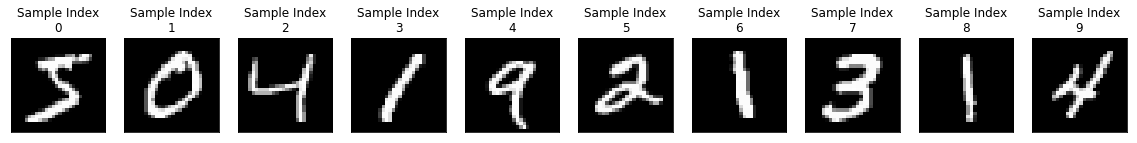

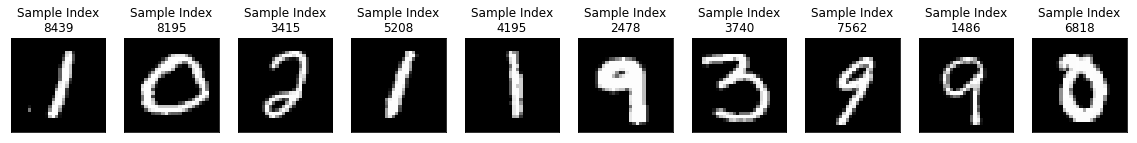

In [214]:
# plot first 10 samples from training data
plot_mnist_sample(mnist_train.train_data, 
                  sample_idx=[i for i in range(10)])
# plot 10 random samples of test data 
plot_mnist_sample(mnist_test.test_data, size=10)


# Check Transformation
- Transform MNIST to [0, 1]
- Check transformation is correct

n.shape: (60000, 28, 28, 1)
torch.Size([1, 28, 28])
Original max values: 255
Transformed max values: 1.0
Reverse back to original, max values: 255
Is original equal to reversed transformed tensor: True


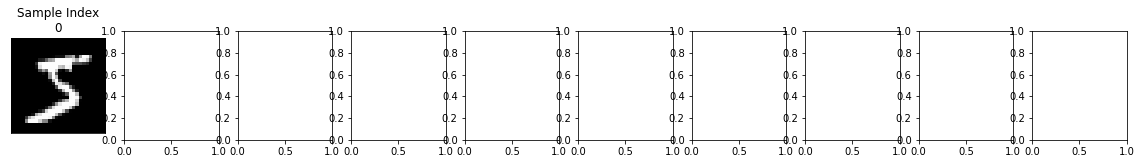

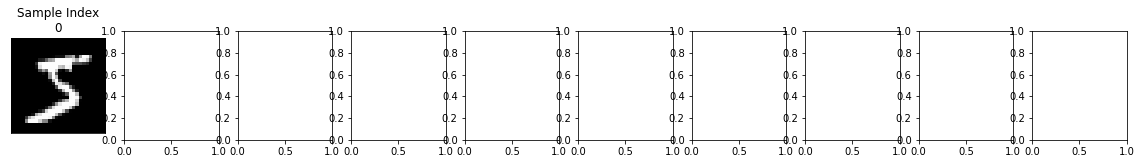

In [7]:
n = mnist_train.train_data.numpy()
n.resize((60000, 28, 28, 1)) # Sample x Height x Width x Channel
print("n.shape:", n.shape) # Sample x Height x Width x Channel

tensor_0 = mnist_train.transform(n[0]) # first sample after transformation
print(tensor_0.size())
# plot first training sample
plot_mnist_sample(tensor_0, sample_idx=[0])
plot_mnist_sample(mnist_train.train_data, sample_idx=[0])

n_0_flatten = n[0, :, :, 0].reshape(784)
print("Original max values:", n_0_flatten.max())
print("Transformed max values:", tensor_0[0, :, :].numpy().max())
tensor_0_flattern_reverse = tensor_0[0, :, :].numpy() * 255
tensor_0_flattern_reverse = tensor_0_flattern_reverse.reshape(784).astype(int)
print("Reverse back to original, max values:", tensor_0_flattern_reverse.max())
print("Is original equal to reversed transformed tensor:",np.equal(n_0_flatten, tensor_0_flattern_reverse).sum() == 784)

# MNIST Data Loader

In [8]:
mnist_train_loader = torch.utils.data.DataLoader(mnist_train, 
                        batch_size=args.train_batch_size,
                        shuffle=True, 
                        **kwargs)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test, 
                        batch_size=args.test_batch_size,
                        shuffle=True, 
                        **kwargs)

# Using Feed Forward Network as Autoencoder in AAE

In [182]:
x_dim = 784 # input dimension to Encoder
z_dim = 2 # latent space dimension

class Encoder(nn.Module):
    """Encoder of AAE, it extends base class for neural network modules.
    
    Input values to the Encoder are in the range [0.0, 1.0].
    """
    def __init__(self):
        super(Encoder, self).__init__()
        # nn.Linear:
        # Layer of weights and bias that performs linear transformation to incomming data
        # output of each layer: y = Ax + B
        # where A is the weight of the layer and B the bias
        self.lin1 = nn.Linear(x_dim, 1000) # 1000 output dimension with X_dim input dimension 
        self.lin2 = nn.Linear(1000, 1000) # 1000 output dimension with 1000 input dimension
        self.lin3 = nn.Linear(1000, z_dim) # z_dim output dimension from 1000 input dimension
    
    def forward(self, x):
        """Defines the forward computation.
        """
        x = self.lin1(x)
        x = F.dropout(x, p=0.1, training=self.training, inplace=False)
        x = F.relu(x, inplace=False)
        x = self.lin2(x)
        x = F.dropout(x, p=0.1, training=self.training, inplace=False)
        x = F.relu(x, inplace=False)
        return self.lin3(x)

class Decoder(nn.Module):
    """Decoder of AAE, it extends base class for neural network modules.
    
    Output values of Decoder are in the range [0.0, 1.0].
    """
    def __init__(self):
        super(Decoder, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, x_dim)
    
    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.1, training=self.training, inplace=False)
        x = F.relu(x, inplace=False)
        x = self.lin2(x)
        x = F.dropout(x, p=0.1, training=self.training, inplace=False)
        x = self.lin3(x)
        # ouput values are in range [0.0, 1.0] to match range of input values
        # to the Encoder
        return F.sigmoid(x)

class Discriminator(nn.Module):
    """Discriminator of AAE, it extends base class of neural network modules.
    
    Output of Discriminator is in range [0.0, 1.0]
    """
    def __init__(self):
        super(Discriminator, self).__init__()
        self.lin1 = nn.Linear(z_dim, 1000)
        self.lin2 = nn.Linear(1000, 1000)
        self.lin3 = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = F.dropout(x, p=0.1, training=self.training, inplace=False)
        x = F.relu(x)
        x = self.lin2(x)
        x = F.dropout(x, p=0.1, training=self.training, inplace=False)
        x = F.relu(x)
        x = self.lin3(x)
        return F.sigmoid(x)

In [199]:
nn_enc = Encoder()
nn_dec = Decoder()
nn_dis = Discriminator()
if args.cuda:
    nn_enc.cuda()
    nn_dec.cuda()
    nn_dis.cuda()
    

In [200]:
optim_enc = optim.Adam(nn_enc.parameters(), lr=0.001)
optim_dec = optim.Adam(nn_dec.parameters(), lr=0.001)
optim_gen = optim.Adam(nn_enc.parameters(), lr=0.001)
optim_dis = optim.Adam(nn_dis.parameters(), lr=0.001)

In [ ]:
TINY = 1e-15
# set networks to training mode
# this has any effect only on modules such as Dropout or BatchNorm
nn_enc.train()
nn_dec.train()
nn_dis.train()
# train networks
for epoch in tqdm.tqdm_notebook(range(1, args.epochs+1), "Epoch"):    
    total_recon_loss = 0
    total_gen_loss = 0
    total_dis_loss = 0
    
    for batch_idx, (x, y) in enumerate(mnist_train_loader):
        # resizing data tensor from [batch_size, 1, 28, 28] to [batch_size, 784]
        x = x.view(-1, 784)
        #print(batch_idx, x.shape, y.shape)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x, y = x.cuda(), y.cuda()

        # reconstruction phase
        # clear the gradients of all optimised variables (of type Variable)
        optim_dec.zero_grad()
        optim_enc.zero_grad()
        z = nn_enc(x)
        recon_x = nn_dec(z)
        recon_loss = F.binary_cross_entropy(recon_x, x, 
                                            weight=None, 
                                            size_average=False)
        total_recon_loss += recon_loss.data[0]
        # compute gradient of recon_loss Variable
        recon_loss.backward()
        # perform a single optimisation step (parameter update) to decoder
        optim_dec.step()
        # perform a single optimisation step (parameter update) to encoder
        optim_enc.step()

        # regularisation phase
        # clear the gradients of all optimised variables (of type Variable)
        optim_dis.zero_grad()
        optim_gen.zero_grad()
        # sample real z
        # returns a Tensor filled with random numbers from a normal distribution
        # with zero mean and standard dev. of 5
        z_real = Variable(torch.randn(len(x), z_dim) * 5.0)
        if args.cuda:
            z_real = z_real.cuda()
        # set generator network to evaluation mode 
        # this has any effect only on modules such as Dropout or BatchNorm
        nn_enc.eval()
        z_fake = nn_enc(x)
        prob_z_real = nn_dis(z_real)
        prob_z_fake = nn_dis(z_fake)
        dis_loss = -torch.mean(torch.log(prob_z_real+TINY) + 
                               torch.log(1 - prob_z_fake+TINY))
        total_dis_loss += dis_loss.data[0]
        dis_loss.backward()
        optim_dis.step()

        # set generator to training mode
        nn_enc.train()
        z_fake = nn_enc(x)
        prob_z_fake = nn_dis(z_fake)
        gen_loss = -torch.mean(torch.log(prob_z_fake+TINY))
        total_gen_loss += gen_loss.data[0]
        gen_loss.backward()
        optim_gen.step()
        if (not args.log_interval is None) and (batch_idx % args.log_interval == 0):
            print('Epoch:{} [{}/{} ({:.0f}%)] recon_loss:{:.6f} dis_loss:{:.6f} gen_loss:{:.6f}'.format(
                epoch, 
                batch_idx * len(x), 
                len(mnist_train_loader.dataset),
                100. * batch_idx / len(mnist_train_loader),
                recon_loss.data[0] / len(x),
                dis_loss.data[0] / len(x),
                gen_loss.data[0] / len(x)))

    print('Epoch:{} avg recon_loss:{:.6f} avg dis_loss:{:.6f} avg gen_loss:{:.6f}'.format(
          epoch, total_recon_loss / len(mnist_train_loader.dataset), 
          total_dis_loss / len(mnist_train_loader.dataset),
          total_gen_loss / len(mnist_train_loader.dataset)
         ))
    

Epoch:1 avg recon_loss:151.088650 avg dis_loss:0.010610 avg gen_loss:0.008323
Epoch:2 avg recon_loss:151.237702 avg dis_loss:0.010574 avg gen_loss:0.008432
Epoch:3 avg recon_loss:151.013370 avg dis_loss:0.010598 avg gen_loss:0.008302
Epoch:4 avg recon_loss:150.964072 avg dis_loss:0.010633 avg gen_loss:0.008344
Epoch:5 avg recon_loss:150.804461 avg dis_loss:0.010679 avg gen_loss:0.008331
Epoch:6 avg recon_loss:150.875426 avg dis_loss:0.010631 avg gen_loss:0.008319
Epoch:7 avg recon_loss:150.765385 avg dis_loss:0.010699 avg gen_loss:0.008258
Epoch:8 avg recon_loss:150.897099 avg dis_loss:0.010668 avg gen_loss:0.008265
Epoch:9 avg recon_loss:150.816276 avg dis_loss:0.010604 avg gen_loss:0.008166
Epoch:10 avg recon_loss:150.888591 avg dis_loss:0.010578 avg gen_loss:0.008326
Epoch:11 avg recon_loss:150.884070 avg dis_loss:0.010591 avg gen_loss:0.008319
Epoch:12 avg recon_loss:150.890047 avg dis_loss:0.010552 avg gen_loss:0.008263
Epoch:13 avg recon_loss:150.918795 avg dis_loss:0.010552 avg 

In [ ]:
def create_latent(nn_enc, loader):
    '''
    Create the latent representation for the samples in loader
    Return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    nn_enc.eval()
    labels = []
    for batch_idx, (x, y) in enumerate(loader):
        x = x.view(-1, 784)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        labels.extend(y.data.tolist())
        # reconstruction phase
        z = nn_enc(x)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z.data.tolist())))
        else:
            z_values = np.array(z.data.tolist())
    labels = np.array(labels)
    return z_values, labels


def create_sample(nn_dec, z_values):
    """Evaluate Decoder.
    
    Return FloatTensor of shape [sample count, 28, 28].
    """
    z = torch.from_numpy(z_values).float()
    z = Variable(z)
    nn_dec.eval()
    recon_x = nn_dec(z)
    recon_x = recon_x.view(len(recon_x.data), 28, -1)
    return recon_x.data

# Reconstruction of MNIST Training Samples

-0.348802065066 5.76069712656
-1.61623821421 5.10297177794


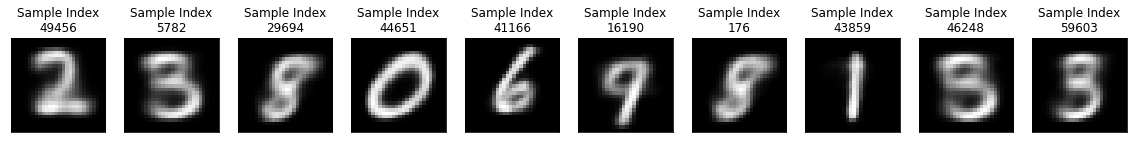

In [220]:
z_values, _ = create_latent(nn_enc, mnist_train_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = create_sample(nn_dec, z_values)
plot_mnist_sample(recon_x)

# Latent Code of MNIST Training Samples

-0.348802065066 5.76069712656
-1.61623821421 5.10297177794


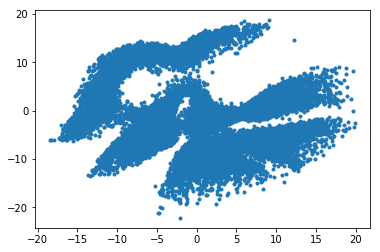

In [221]:
z_values, labels = create_latent(nn_enc, mnist_train_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
plt.plot(z_values[:,0], z_values[:,1], ".")

# Reconstruction of MNIST Testing Samples

-0.499233338302 5.66788380999
-1.68567172102 4.93254568788


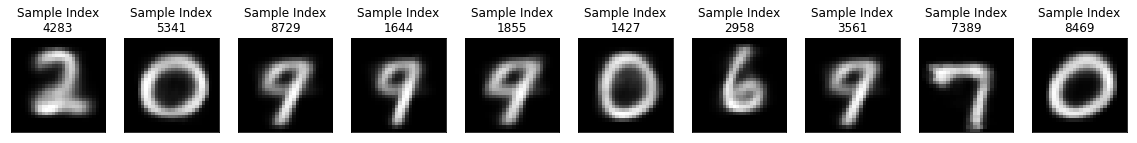

In [222]:
z_values, _ = create_latent(nn_enc, mnist_test_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = create_sample(nn_dec, z_values)
plot_mnist_sample(recon_x)

# Latent Code of MNIST Testing Samples

-0.499233338302 5.66788380999
-1.68567172102 4.93254568788


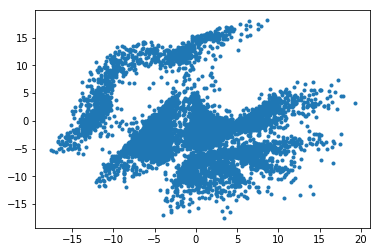

In [223]:
z_values, labels = create_latent(nn_enc, mnist_test_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
plt.plot(z_values[:,0], z_values[:,1], ".")

# Using Variational Autoencoder in AAE

In [124]:
x_dim = 784
z_dim = 2
"""
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(x_dim, 500)
        self.fc21 = nn.Linear(500, z_dim)
        self.fc22 = nn.Linear(500, z_dim)
        self.fc3 = nn.Linear(z_dim, 500)
        self.fc4 = nn.Linear(500, x_dim)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        # perform element-wise exp(logvar/2)
        std = logvar.mul(0.5).exp_()
        # sample from normal distribution of mean=0 and std=1
        # fills this tensor (eps) with elements samples from the 
        # normal distribution parameterized by mean=0 and std=1.
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def latent(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z
    
    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
"""
class VAE_Encoder(nn.Module):
    def __init__(self):
        super(VAE_Encoder, self).__init__()
        self.fc1 = nn.Linear(x_dim, 500)
        self.fc21 = nn.Linear(500, z_dim)
        self.fc22 = nn.Linear(500, z_dim)
        self.relu = nn.ReLU()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        # perform element-wise exp(logvar/2)
        std = logvar.mul(0.5).exp_()
        # sample from normal distribution of mean=0 and std=1
        # fills this tensor (eps) with elements samples from the 
        # normal distribution parameterized by mean=0 and std=1.
        if args.cuda:
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
         # wrap tensor into torch.autograd.Variable (automatic differentiation)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return z
        
class VAE_Decoder(nn.Module):
    def __init__(self):
        super(VAE_Decoder, self).__init__()
        self.fc3 = nn.Linear(z_dim, 500)
        self.fc4 = nn.Linear(500, x_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.nn_enc = VAE_Encoder()
        self.nn_dec = VAE_Decoder()

    def latent(self, x):
        z = self.nn_enc.forward(x)
        return z
    
    def decode(self, z):
        return self.nn_dec.forward(z)

    def forward(self, x):
        mu, logvar = self.nn_enc.encode(x)
        z = self.nn_enc.reparametrize(mu, logvar)
        return self.nn_dec(z), mu, logvar

In [149]:
nn_vae = VAE()
nn_vae_dis = Discriminator()
if args.cuda:
    nn_vae.cuda()
    nn_vae_dis.cuda()

print("VAE Modules")
for idx, m in enumerate(nn_vae.modules()):
    print(idx, '->', m)
print("VAE Parameters")
for param in nn_vae.parameters():
    print(type(param.data), param.size())
    
print("Discriminator")
for param in nn_vae_dis.parameters():
    print(type(param.data), param.size())

VAE Modules
0 -> VAE (
  (nn_enc): VAE_Encoder (
    (fc1): Linear (784 -> 500)
    (fc21): Linear (500 -> 2)
    (fc22): Linear (500 -> 2)
    (relu): ReLU ()
  )
  (nn_dec): VAE_Decoder (
    (fc3): Linear (2 -> 500)
    (fc4): Linear (500 -> 784)
    (relu): ReLU ()
    (sigmoid): Sigmoid ()
  )
)
1 -> VAE_Encoder (
  (fc1): Linear (784 -> 500)
  (fc21): Linear (500 -> 2)
  (fc22): Linear (500 -> 2)
  (relu): ReLU ()
)
2 -> Linear (784 -> 500)
3 -> Linear (500 -> 2)
4 -> Linear (500 -> 2)
5 -> ReLU ()
6 -> VAE_Decoder (
  (fc3): Linear (2 -> 500)
  (fc4): Linear (500 -> 784)
  (relu): ReLU ()
  (sigmoid): Sigmoid ()
)
7 -> Linear (2 -> 500)
8 -> Linear (500 -> 784)
9 -> ReLU ()
10 -> Sigmoid ()
VAE Parameters
<class 'torch.FloatTensor'> torch.Size([500, 784])
<class 'torch.FloatTensor'> torch.Size([500])
<class 'torch.FloatTensor'> torch.Size([2, 500])
<class 'torch.FloatTensor'> torch.Size([2])
<class 'torch.FloatTensor'> torch.Size([2, 500])
<class 'torch.FloatTensor'> torch.Size(

In [134]:
TINY = 1e-15
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, 
                                 weight=None,
                                 size_average=False)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return BCE + KLD

In [137]:
optim_vae = optim.Adam(nn_vae.parameters(), lr=0.005)
optim_vae_gen = optim.Adam(nn_vae.nn_enc.parameters(), lr=0.0002)
optim_vae_dis = optim.Adam(nn_vae_dis.parameters(), lr=0.0002)

In [138]:
nn_vae.train()
nn_vae.nn_enc.train()
nn_vae.nn_dec.train()
nn_vae_dis.train()
for epoch in tqdm.tqdm_notebook(range(1, args.epochs+1), "Epoch"):
    train_loss = 0
    total_dis_loss = 0
    total_gen_loss = 0
    for batch_idx, (x, y) in enumerate(mnist_train_loader):
        x = x.view(-1, 784)
        x = Variable(x)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        # reconstruction phase
        optim_vae.zero_grad()
        nn_vae.nn_dec.zero_grad()
        nn_vae.nn_enc.zero_grad()
        recon_batch, mu, logvar = nn_vae(x)
        loss = loss_function(recon_batch, x, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optim_vae.step()
        
        # regularisation phase
        # clear the gradients of all optimised variables (of type Variable)
        optim_vae_dis.zero_grad()
        optim_vae_gen.zero_grad()
        # sample real z
        # returns a Tensor filled with random numbers from a normal distribution
        # with zero mean and standard deviation of 1
        z_real = Variable(torch.randn(len(x), z_dim) * 1.0)
        if args.cuda:
            z_real = z_real.cuda()
        # set generator network to evaluation mode 
        # this has any effect only on modules such as Dropout or BatchNorm
        nn_vae.nn_enc.eval()
        z_fake = nn_vae.nn_enc(x)
        prob_z_real = nn_vae_dis(z_real)
        prob_z_fake = nn_vae_dis(z_fake)
        dis_loss = -torch.mean(torch.log(prob_z_real+TINY) + 
                               torch.log(1 - prob_z_fake+TINY))
        total_dis_loss += dis_loss.data[0]
        dis_loss.backward()
        optim_vae_dis.step()

        # set generator to training mode
        nn_vae.nn_enc.train()
        optim_vae_gen.zero_grad()
        z_fake = nn_vae.nn_enc(x)
        prob_z_fake = nn_vae_dis(z_fake)
        gen_loss = -torch.mean(torch.log(prob_z_fake+TINY))
        total_gen_loss += gen_loss.data[0]
        gen_loss.backward()
        optim_vae_gen.step()
        
        if (not args.log_interval is None) and (batch_idx % args.log_interval == 0):
            print('Epoch:{} [{}/{} ({:.0f}%)] recon_loss:{:.6f} dis_loss:{:.6f} gen_loss:{:.6f}'.format(
                epoch, batch_idx * len(x), len(mnist_train_loader.dataset),
                100. * batch_idx / len(mnist_train_loader),
                loss.data[0] / len(x),
                dis_loss.data[0] / len(x),
                gen_loss.data[0] / len(x)
                ))

    print('Epoch:{} avg recon_loss:{:.6f} avg dis_loss:{:.6f} avg gen_loss:{:.6f}'.format(
          epoch, train_loss / len(mnist_train_loader.dataset),
          total_dis_loss / len(mnist_train_loader.dataset),
          total_gen_loss / len(mnist_train_loader.dataset)))
    


Epoch:1 avg recon_loss:165.408058 avg dis_loss:0.012341 avg gen_loss:0.018140
Epoch:2 avg recon_loss:161.428636 avg dis_loss:0.012059 avg gen_loss:0.015963
Epoch:3 avg recon_loss:160.198801 avg dis_loss:0.012015 avg gen_loss:0.016205
Epoch:4 avg recon_loss:159.317463 avg dis_loss:0.011966 avg gen_loss:0.016599
Epoch:5 avg recon_loss:158.903378 avg dis_loss:0.011868 avg gen_loss:0.017596
Epoch:6 avg recon_loss:158.525073 avg dis_loss:0.011764 avg gen_loss:0.018394
Epoch:7 avg recon_loss:158.532420 avg dis_loss:0.011596 avg gen_loss:0.019190
Epoch:8 avg recon_loss:158.501197 avg dis_loss:0.011467 avg gen_loss:0.020399
Epoch:9 avg recon_loss:158.046065 avg dis_loss:0.011444 avg gen_loss:0.020387
Epoch:10 avg recon_loss:158.413224 avg dis_loss:0.011252 avg gen_loss:0.021470



In [139]:
def vae_latent(nn_vae, loader):
    '''
    Create the latent representation for the samples in loader
    Return:
        z_values: numpy array with the latent representations
        labels: the labels corresponding to the latent representations
    '''
    nn_vae.eval()
    labels = []
    for batch_idx, (x, y) in enumerate(loader):
        x = x.view(-1, 784)
        x, y = Variable(x), Variable(y)
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        
        labels.extend(y.data.tolist())
        # reconstruction phase
        z = nn_vae.latent(x)
        if batch_idx > 0:
            z_values = np.concatenate((z_values, np.array(z.data.tolist())))
        else:
            z_values = np.array(z.data.tolist())
    labels = np.array(labels)
    return z_values, labels


def vae_recon(nn_vae, z_values):
    """Evaluate Decoder.
    
    Return FloatTensor of shape [sample count, 28, 28].
    """
    z = torch.from_numpy(z_values).float()
    z = Variable(z)
    nn_vae.eval()
    recon_x = nn_vae.decode(z)
    recon_x = recon_x.view(len(recon_x.data), 28, -1)
    return recon_x.data

-0.12461129473 1.98783019061
0.0093081950643 1.81145709468


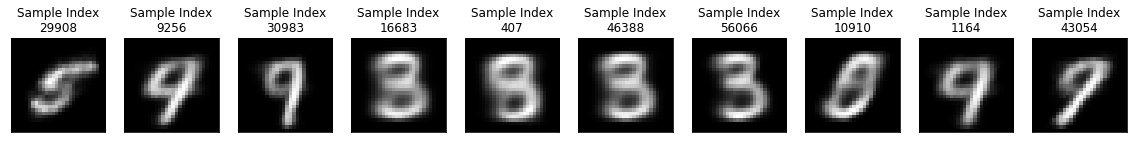

In [140]:
# Reconstruction of MNIST Training Samples
z_values, _ = vae_latent(nn_vae, mnist_train_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = vae_recon(nn_vae, z_values)
plot_mnist_sample(recon_x)


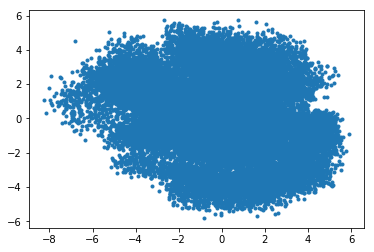

In [143]:
z_values, labels = vae_latent(nn_vae, mnist_train_loader)
plt.plot(z_values[:,0], z_values[:,1], ".")

-0.0953962421795 1.9676685155
0.0392818528105 1.80957088616


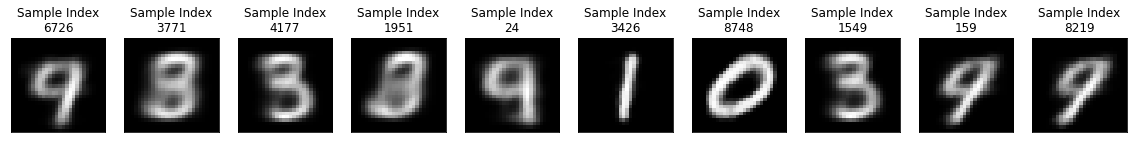

In [141]:
# Reconstruction of MNIST Testing Samples
z_values, _ = vae_latent(nn_vae, mnist_test_loader)
print(z_values[:,0].mean(), z_values[:,0].std())
print(z_values[:,1].mean(), z_values[:,1].std())
recon_x = vae_recon(nn_vae, z_values)
plot_mnist_sample(recon_x)

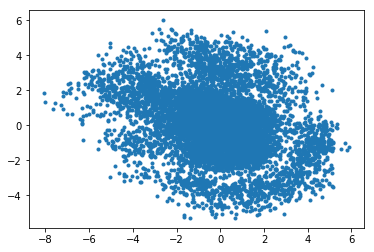

In [142]:
z_values, labels = vae_latent(nn_vae, mnist_test_loader)
plt.plot(z_values[:,0], z_values[:,1], ".")